In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

from pathlib import Path
from PIL import Image
import pandas as pd
from collections import Counter


📂 Loading dataset from: D:\Bachelor_project\data\subset_pneumonia_30.csv
✅ Dataset Loaded: train set with 24 samples.
🖼 Image batch shape: torch.Size([4, 1, 224, 224])
📝 First report:
                                  FINAL REPORT
 INDICATION:  Evaluate for pneumonia in a patient with progressive decline.
 
 TECHNIQUE:  Chest PA and lateral
 
 COMPARISON:  Chest radiographs from ___ and ___.
 
 FINDINGS: 
 
 Frontal and lateral chest radiographs demonstrate bilateral pleural effusions,
 which make evaluation of the cardiomediastinal silhouette difficulty.  These
 effusions are large on the right and small on the left.  There is no definite
 focal consolidation, although evaluation is limited secondary to these
 effusions.  No pneumothorax is appreciated.  The visualized upper abdomen is
 unremarkable.
 
 IMPRESSION: 
 
 Bilateral pleural effusions, large on the right and small on the left.  No
 definite focal consolidation identified, although evaluation is limited
 secondary to these 

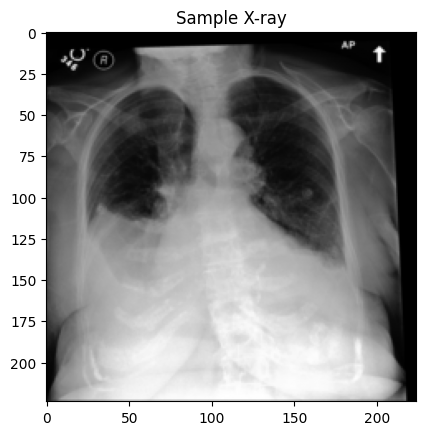

In [2]:
from data import get_dataloader

train_loader = get_dataloader("train", batch_size=4, shuffle=True)

# Show a sample batch
images, reports, labels = next(iter(train_loader))
print("🖼 Image batch shape:", images.shape)
print("📝 First report:\n", reports[0])
print("🏷 Label:", labels[0].item())

plt.imshow(images[0].squeeze(), cmap='gray')
plt.title("Sample X-ray")
plt.show()


In [3]:
class Vocabulary:
    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.freqs = Counter()
        self.next_index = 4

    def build_vocab(self, texts):
        for line in texts:
            tokens = line.lower().split()
            self.freqs.update(tokens)

        for word, freq in self.freqs.items():
            if freq >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = self.next_index
                self.idx2word[self.next_index] = word
                self.next_index += 1

    def encode(self, text, max_len=50):
        tokens = text.lower().split()
        ids = [self.word2idx.get(tok, self.word2idx["<UNK>"]) for tok in tokens]
        ids = [self.word2idx["<SOS>"]] + ids[:max_len - 2] + [self.word2idx["<EOS>"]]
        ids += [self.word2idx["<PAD>"]] * (max_len - len(ids))
        return torch.tensor(ids)

    def decode(self, ids):
        words = [self.idx2word.get(i, "<UNK>") for i in ids]
        return " ".join(words).replace("<PAD>", "").strip()

vocab = Vocabulary(min_freq=2)
vocab.build_vocab(reports)

# Test vocab
encoded = vocab.encode(reports[0])
decoded = vocab.decode(encoded.tolist())
print("Encoded:", encoded)
print("Decoded:", decoded)


Encoded: tensor([ 1,  4,  5,  6,  3,  3,  3,  7,  3,  8,  9,  3,  3, 10, 11,  3, 12, 13,
        14, 11, 15, 16, 17, 12, 18, 19, 20, 12, 13, 11, 15,  3, 21, 22, 23,  3,
         3, 24, 25, 26,  3, 27,  3, 28,  3, 29, 30, 31, 26,  2])
Decoded: <SOS> final report indication: <UNK> <UNK> <UNK> in <UNK> patient with <UNK> <UNK> technique: chest <UNK> and lateral comparison: chest radiographs from ___ and ___. findings: frontal and lateral chest radiographs <UNK> bilateral pleural effusions, <UNK> <UNK> evaluation of the <UNK> silhouette <UNK> these <UNK> are large on the <EOS>


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 28x28
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # 1x1
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self, x):
        features = self.encoder(x)
        return self.fc(features.view(x.size(0), -1))


In [8]:
class TextDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gru_input_proj = nn.Linear(embed_dim + hidden_dim, embed_dim)  # NEW!
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, captions, features):
        embedded = self.embed(captions)  # [B, L, 256]
        features = features.unsqueeze(1).repeat(1, embedded.size(1), 1)  # [B, L, 256]
        x = torch.cat((features, embedded), dim=2)  # [B, L, 512]
        x = self.gru_input_proj(x)  # [B, L, 256]
        output, _ = self.gru(x)
        return self.fc(output)


In [9]:
cnn = SimpleCNN(out_dim=256)
decoder = TextDecoder(vocab_size=len(vocab.word2idx))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn, decoder = cnn.to(device), decoder.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"])
optimizer = optim.Adam(list(cnn.parameters()) + list(decoder.parameters()), lr=1e-3)


In [10]:
cnn.train()
decoder.train()

for images, reports, _ in train_loader:
    images = images.to(device)
    targets = torch.stack([vocab.encode(r) for r in reports]).to(device)

    inputs = targets[:, :-1]  # everything except last token
    labels = targets[:, 1:]   # everything except first token

    optimizer.zero_grad()
    img_features = cnn(images)
    outputs = decoder(inputs, img_features)
    loss = criterion(outputs.view(-1, len(vocab.word2idx)), labels.reshape(-1))
    loss.backward()
    optimizer.step()

    print("Loss:", loss.item())

    # Show prediction
    pred_ids = outputs.argmax(dim=-1)[0].tolist()
    print("Generated:", vocab.decode(pred_ids))
    print("Target:", reports[0])
    break


Loss: 4.3524088859558105
Generated: patient hx patient hx patient is is cardiopulmonary s/p s/p cardiopulmonary cardiopulmonary cardiopulmonary s/p s/p s/p cardiopulmonary cardiopulmonary is is patient cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary indication: patient is or cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary size patient cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary patient is cardiopulmonary patient cardiopulmonary patient is cardiopulmonary
Target:                                  FINAL REPORT
 CHEST RADIOGRAPHS
 
 HISTORY:  Metastatic disease with known pulmonary metastases, presenting with
 fever and leukocytosis.
 
 COMPARISONS:  Radiographs from ___ as well as CT of the abdomen
 and pelvis from that same day.  Radiographs are also available from ___.
 
 FINDINGS:  The lung volumes are low.  The cardiac, mediastinal and hilar
 contours appear unchanged, allowing for differences in techn

In [ ]:
def generate(image_tensor, max_len=30):
    cnn.eval()
    decoder.eval()
    with torch.no_grad():
        feature = cnn(image_tensor.unsqueeze(0).to(device))
        generated = [vocab.word2idx["<SOS>"]]

        for _ in range(max_len):
            input_seq = torch.tensor(generated).unsqueeze(0).to(device)
            output = decoder(input_seq, feature)
            next_word = output.argmax(2)[:, -1].item()
            if next_word == vocab.word2idx["<EOS>"]:
                break
            generated.append(next_word)

        return vocab.decode(generated)

# Try generating
gen_text = generate(images[0])
print("🧠 Generated report:\n", gen_text)
print("📝 Ground truth:\n", reports[0])


🧠 Generated report:
 <SOS> report patient clear frontal chest radiographs are patient are patient hx pneumothorax. pneumothorax. cardiopulmonary cardiopulmonary cardiopulmonary cardiopulmonary enteric from <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
📝 Ground truth:
                                  FINAL REPORT
 CHEST RADIOGRAPHS
 
 HISTORY:  Metastatic disease with known pulmonary metastases, presenting with
 fever and leukocytosis.
 
 COMPARISONS:  Radiographs from ___ as well as CT of the abdomen
 and pelvis from that same day.  Radiographs are also available from ___.
 
 FINDINGS:  The lung volumes are low.  The cardiac, mediastinal and hilar
 contours appear unchanged, allowing for differences in technique.  There are a
 number of round nodular densities projecting over each upper lung, but more
 numerous and discretely visualized in the left upper lobe, similar to prior
 study.  However, in addition, there is a more hazy widespread opacity
 projecting over t